## Movielens

In [1]:
from fastai.learner import *
from fastai.column_data import *
import os
import pandas as pd

Define the path to the dataset

In [2]:
path='./data/ml-latest-small/'

In [3]:
os.listdir(path)

['links.csv', 'movies.csv', 'ratings.csv', 'README.txt', 'tags.csv']

Visualize the ratings csv file

In [4]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


As we can see, it represents the ratings a user has given to each movie it has rated.

Visualize the movies csv

In [5]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


The movies csv maps the moveId to the title and the genres it belongs

## Collaborative filtering

Collaborative filtering builds a predictive model that will map the user to the ratings it would give to movies.<br>
Interestingly enough, to build such model, we create a high dimensional space to define the user tastes and a linear transformation based on the movie attributes to map to the final rating.<br><br>

So let's start with the user high dimensional space.<br>
As we have seen before, we can represent a concept by attaching multiple one-dimensional attributes to it.<br>
In this case, we could define a user by the enthusiasm it has for romance, action, length of the movie, special effects...<br>
All in all, with the awsome pattern recognition a deep neural network brings, with enough iterations this dimensions will evolve into the user tastes attributes that make up for the best predictions. These might be weird correlations and attributes we don't have a natural way of expressing but these are garanteed to be the best predictors.<br><br>

So about the linear transformation by movies attributes.<br>
Movies can also be defined by a high dimensional set of attributes.<br>
In this case, we want such attributes to directly match the user tastes attributes. This way, the ratings can be thought as a linear transformation of the movie attributes over the user tastes.<br><br>

So in the end we are trying to find the set of attributes and the linear transformation that will better map to the user ratings.


## Parameters settings

Define the percentage of the validation set.

In [7]:
val_idxs = get_cv_idxs(len(ratings), val_pct=0.2)

To apply L2 regularitzation where we sum the square of the parameters multiplied by lambda in the cost function we must first define lambda.

In [8]:
weight_decay = 2e-4

The number of factors define the amount of dimensions we will extract for both users and movies.

In [9]:
n_factors = 50

To define the data object we simply define the path, the csv file, the user id, the movie id and the dependant variable we are trying to predict.

In [10]:
data = CollabFilterDataset.from_csv(path=path, csv='ratings.csv', user_name='userId', item_name='movieId', rating_name='rating')

For the learner object we define the n_factors, val_idxs, the mini-batch size and the optimization function.

In [12]:
learn = data.get_learner(n_factors=n_factors, val_idxs=val_idxs, bs=64, opt_fn=optim.Adam)

Training

In [16]:
learn.fit(1e-2, 2, wds=weight_decay, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                  
    0      0.753683   0.778597  
    1      0.728342   0.777182                                  
    2      0.506433   0.767976                                  



[array([0.76798])]

The default metric is mean squared error (MSE), we will take the best value we got for the validation loss and compare it to some benchmarks. Frist we will obtain the root mean squared error to use the same metric.

In [15]:
math.sqrt(0.7652)

0.8747571091451615

The best value we found is 0.851. As we can see we are very close.

## Analyze the results

### Bias

Let's check the bias (difference between real and predicted value) we got for the top rated movies.

In [39]:
movies_names = movies.set_index('movieId')['title'].to_dict() # Dictionary mapping the movie id to the title
movies_sum_ratings = ratings.groupby('movieId')['rating'].count() # Create a dataframe with movieId and the cumulative sum of ratings
most_rated_movies_idx = movies_sum_ratings.sort_values(ascending=False).index.values[:3000] # Get the indexes of the csv of top rated movies
top_movies_idx = np.array([data.item2idx[o] for o in most_rated_movies_idx]) # Get the indexes of the data object of the top rated movies

Lets load the model object

In [41]:
model = learn.model; model.cuda()

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

Get the bias for each of the movies

In [43]:
movie_bias = to_np(model.ib(V(top_movies_idx))) # model index bias

In [46]:
movie_bias

array([[0.78177],
       [0.90917],
       [1.33984],
       ...,
       [0.30371],
       [0.02203],
       [0.1687 ]], dtype=float32)

Create a list with the movie bias and the movie name.

In [47]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

In [48]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-1.1530029, 'Battlefield Earth (2000)'),
 (-0.8698644, 'Anaconda (1997)'),
 (-0.85809314, 'Speed 2: Cruise Control (1997)'),
 (-0.8205121, 'Super Mario Bros. (1993)'),
 (-0.7879608, 'Batman & Robin (1997)'),
 (-0.7879399, 'Wild Wild West (1999)'),
 (-0.74234456, 'Congo (1995)'),
 (-0.7392319, 'Flintstones, The (1994)'),
 (-0.7340665, "Joe's Apartment (1996)"),
 (-0.70652956, 'Karate Kid, Part III, The (1989)'),
 (-0.6921999, 'Message in a Bottle (1999)'),
 (-0.67566997, 'Halloween III: Season of the Witch (1982)'),
 (-0.67541856, 'Blade: Trinity (2004)'),
 (-0.6707914, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.6614153, 'Inspector Gadget (1999)')]

### Embedding interpretation

Let's try to understand what do the embeddings represent.

In [49]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

Because it's hard to interpret 50 embeddings, we will use Principant Component Analysis to obtain the 3 most significant embeddings.

In [60]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [61]:
movie_pca.shape

(3, 3000)

Let's analyze the first component

In [62]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

This component seems to represent if the movie is easy or hard to watch. This would be the most significant attribute for most people when deciding which movie to watch

In [63]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.07589751, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.06297179, 'Man in the Iron Mask, The (1998)'),
 (0.06277547, 'Waterworld (1995)'),
 (0.062105298, 'Mission: Impossible II (2000)'),
 (0.061655596, 'Armageddon (1998)'),
 (0.060486514, 'Outbreak (1995)'),
 (0.057359386, 'Miss Congeniality (2000)'),
 (0.055886686, 'Batman Forever (1995)'),
 (0.055003837, 'Coyote Ugly (2000)'),
 (0.05450056, 'Con Air (1997)')]

In [64]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.077190064, 'Taxi Driver (1976)'),
 (-0.07319913, 'Apocalypse Now (1979)'),
 (-0.07257483, 'Casablanca (1942)'),
 (-0.071395494, 'Chinatown (1974)'),
 (-0.071255684, 'Fargo (1996)'),
 (-0.06928011, 'Pulp Fiction (1994)'),
 (-0.06562699, 'Airplane! (1980)'),
 (-0.06521687, '2001: A Space Odyssey (1968)'),
 (-0.05906934, 'Willy Wonka & the Chocolate Factory (1971)'),
 (-0.057332948, 'Raging Bull (1980)')]

Let's analyze the second component

In [65]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component. It seems to be 'CGI' vs 'dialog driven'.

In [66]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.06295034, 'Like Water for Chocolate (Como agua para chocolate) (1992)'),
 (0.06075082, 'English Patient, The (1996)'),
 (0.055519767, 'Specialist, The (1994)'),
 (0.05312329, 'Great Expectations (1998)'),
 (0.05016651, 'Brokeback Mountain (2005)'),
 (0.04735452, 'Thomas Crown Affair, The (1999)'),
 (0.046339214, 'Coneheads (1993)'),
 (0.046246607, 'Nell (1994)'),
 (0.046009094, 'Bend It Like Beckham (2002)'),
 (0.045930956, 'Modern Times (1936)')]

In [67]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.094461806, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (-0.076697916, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (-0.073947564, 'Chasing Amy (1997)'),
 (-0.07090194, 'Happiness (1998)'),
 (-0.070581675, 'Mr. & Mrs. Smith (2005)'),
 (-0.069677554, 'Austin Powers: International Man of Mystery (1997)'),
 (-0.06836876,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (-0.06733849, 'Office Space (1999)'),
 (-0.06670665, 'X-Men (2000)'),
 (-0.06661095, 'Lord of the Rings: The Two Towers, The (2002)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

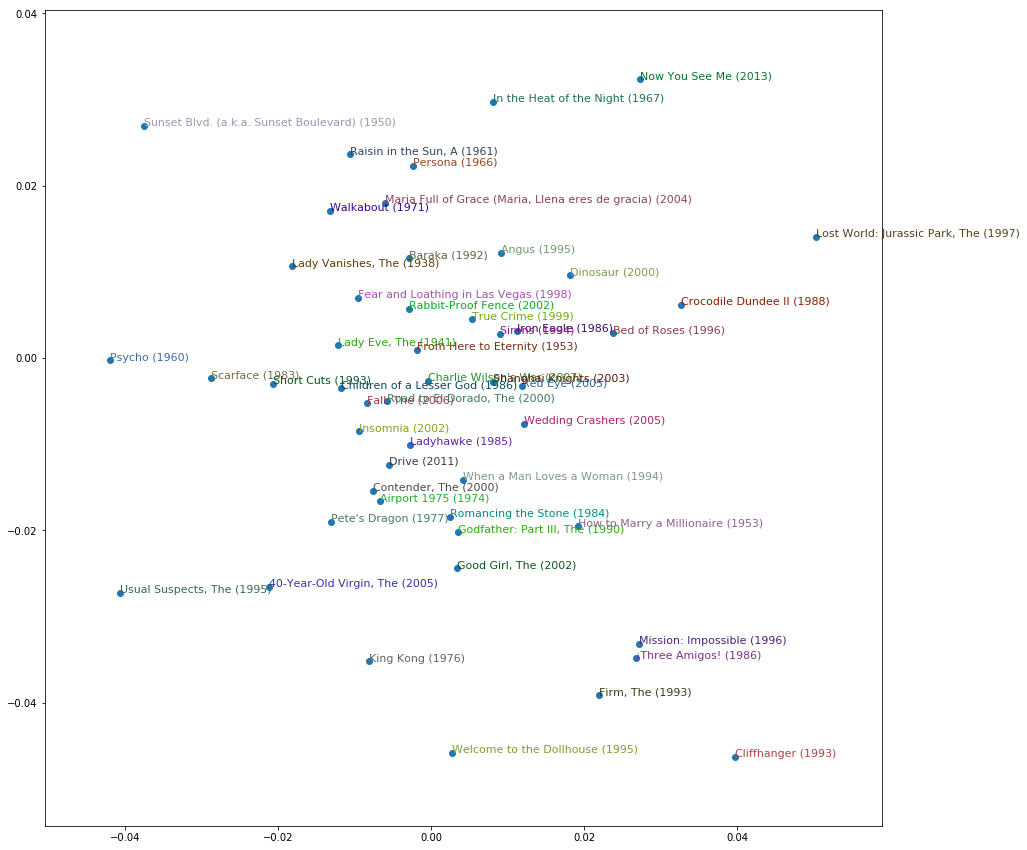

In [68]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

PCA is a great way to visualize high dimensional data in a human readable form.